#SUMÁRIO

>[SUMARIO](#scrollTo=P7B4dLBV-T-g)

>[Introdução](#scrollTo=2x1mGisLH8-_)

>>[Sistema de Arquivos](#scrollTo=lSZ3oQYClr5w)

>>[Sistema de Arquivos Virtual](#scrollTo=OhB4rLALlikQ)

>[](#scrollTo=OhB4rLALlikQ)

>[Aspectos internos do VFS](#scrollTo=p6TJSCxvk_pM)

>>[Superblock](#scrollTo=zG8M7hkLk9FO)

>>[Inode](#scrollTo=g6ntj7DnlAAU)

>>[Dentry](#scrollTo=YpjW2PuslAL5)

>>[Context](#scrollTo=DKSxWtXgk9U2)

>>[File](#scrollTo=FTPxtrUNk_1E)

>[Suporte para os Sistemas de Arquivos](#scrollTo=c2WNdYD_k7Dn)

>>[Register](#scrollTo=cFhzdEbQkoFM)

>>[Unregister](#scrollTo=DvHvwc9Ukhui)

>[Montagem do Sistema de Arquivos](#scrollTo=JyOJQxD--u-1)

>[Chamadas de Sistema](#scrollTo=CaiM7fktkdho)

>>[open](#scrollTo=A-QQrTjO_fkg)

>>[create](#scrollTo=wGjzwJRZ_jPp)

>>[read](#scrollTo=SC1OV7_c_kz5)

>>[write](#scrollTo=fzGbpkTh_oiN)

>>[close](#scrollTo=duqTZ4nO_pnL)

>>[open, create, read, write e close](#scrollTo=6IJx4mHMj3_b)



# Introdução


## Sistema de Arquivos

Um Sistema de Arquivo é um método e uma estrutura de dados que o SO utiliza para controlar como os dados são gerenciados. Esse sistema serve como uma camada intermediária entre os aplicativos e os dispositivos de armazenamento físico, como discos rígidos, SSDs e unidades flash.<br>Existem diversos tipos de Sistemas de arquivo, cada um com sua própria estrutura lógica única para organizar os dados armazenados. Esses tipos de sistemas de arquivos variam em termos de propriedades como velocidade, segurança, tamanho e outras características que são relevantes para suas aplicações específicas.

## Sistema de Arquivos Virtual
O Virtual File System (VFS), ou Sistema de Arquivos Virtual, é uma abstração de um Sistema de Arquivo que oferece uma interface padronizada para que os programas acessem e gerenciem arquivos e diretórios em diferentes sistemas de armazenamento, sejam eles locais ou remotos.

A principal função do VFS é ocultar as complexidades e diferenças entre os vários sistemas de arquivos (como FAT32, NTFS, ext4, HFS+, etc.) e fornecer uma interface consistente para que os aplicativos possam acessar e manipular dados de arquivo.  Ele fornece uma camada de abstração que permite aos aplicativos interagir com os sistemas de arquivos de maneira uniforme, independentemente da tipo do sistema de arquivos subjacente. Por essa camada, queremos dizer que o VFS padroniza as chamadas de sistema que o SO realiza para os sistemas de arquivos, podendo assim, ignorar as características individuais que cada sistema de arquivos possui e relaizar a manipulação e gerenciamento do mesmo de maneira simplificada.


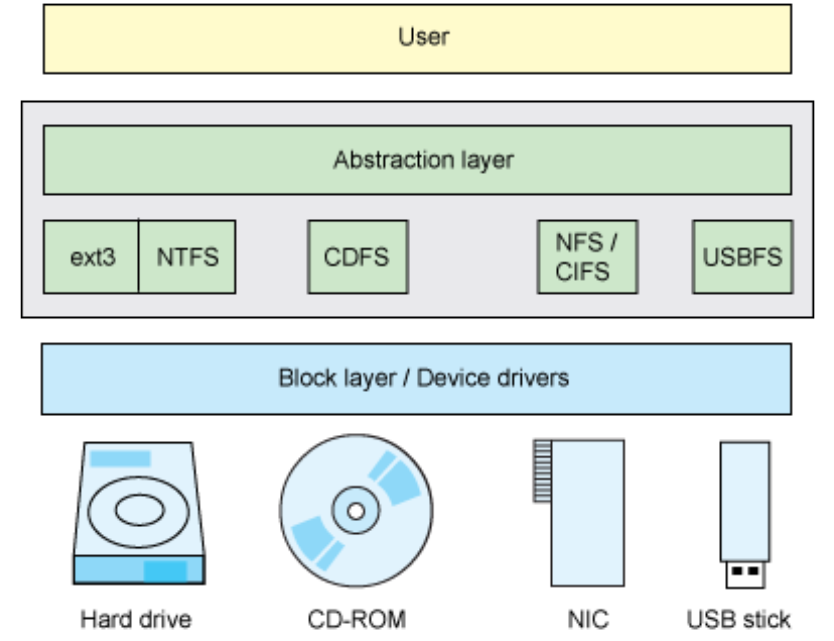

In [ ]:
# @title Estrutura que representa um Sistema de Arquivo: https://elixir.bootlin.com/linux/latest/source/include/linux/fs.h#L2206
struct file_system_type {
    const char *name;                                         /* Nome do tipo de Sistema de Arquivos */
    int fs_flags;                                             /* Flags associadas ao tipo de SA */
#define FS_REQUIRES_DEV          1                            /* Requires a device */
#define FS_BINARY_MOUNTDATA      2                            /* Binary mount data supported */
#define FS_HAS_SUBTYPE           4                            /* Supports subtypes */
#define FS_USERNS_MOUNT          8                            /* Mountable by userns root */
#define FS_DISALLOW_NOTIFY_PERM 16                            /* Disables fanotify permission events */
#define FS_ALLOW_IDMAP          32                            /* Supports vfs idmappings */
#define FS_RENAME_DOES_D_MOVE 32768                           /* Handles d_move() during rename() internally */

    int (*init_fs_context)(struct fs_context *);              /* Função que irá inicializar o contexto do SA para montagem */
    const struct fs_parameter_spec *parameters;               /* Parametros aceitos pelo tipo de SA  */
    struct dentry *(*mount) (struct file_system_type *, int,
               const char *, void *);                         /* Função que irá montar o SA  */
    void (*kill_sb) (struct super_block *);            		    /* Função que limpará o superblock */
    struct module *owner;                                     /* proprietário do módulo  */
    struct file_system_type *next;                            /* Apontador para o próximo SA na lista */
    struct hlist_head fs_supers;                              /* Cabeça da lista hash para os superblocks desse tipo */

    struct lock_class_key s_lock_key;                         /* Estrutura para gerenciar os superblocks */
    struct lock_class_key s_umount_key;
    struct lock_class_key s_vfs_rename_key;
    struct lock_class_key s_writers_key[SB_FREEZE_LEVELS];

    struct lock_class_key i_lock_key;                         /* Estrutura para gerenciar os inodes */
    struct lock_class_key i_mutex_key;
    struct lock_class_key invalidate_lock_key;
    struct lock_class_key i_mutex_dir_key;
};

# Aspectos internos do VFS


O funcionamento do Virtual File System (VFS) é viabilizado por meio do uso de estruturas de dados auxiliares: SUPERBLOCK, INODE, DENTRY e FILE. Essas estruturas são fundamentais para abstrair o acesso entre os diversos tipos de sistemas de arquivos com os quais o VFS interage, oferecendo uma camada de uniformidade na interface que ele disponibiliza para o kernel do sistema operacional.

Uma das características mais notáveis do VFS é a capacidade de permitir que o kernel realize operações em diferentes tipos de sistemas de arquivos de maneira totalmente transparente para o usuário e para o sistema em si. Essa abstração é alcançada através da automatização do processo de "tradução" das operações do VFS para as operações correspondentes no sistema de arquivos subjacente. As rotinas mais essenciais nesse processo incluem MOUNT (montagem), OPEN (abertura), READ (leitura) e WRITE (escrita), cada uma com suas respectivas chamadas de sistema associadas.

Essas chamadas de sistema específicas são invocadas utilizando o ponteiro f_op presente na estrutura FILE, que representa o arquivo. Isso é exemplificado como file->f_op->read(...). A definição dessas operações ocorre no momento do registro de um sistema de arquivos, onde os ponteiros são atribuídos durante o processo de montagem.

Essa abordagem permite a expansão do suporte a novos tipos de sistemas de arquivos de maneira relativamente simples, com a adição de módulos que tratem das funções necessárias e seja montada no sistema, um processo conhecido como registro de um sistema de arquivos. Com isso, o sistema de arquivos adquire suporte para o novo tipo, tornando-o disponível tanto para aplicações quanto para o próprio kernel.


## Superblock

O superbloco serve como um contêiner de metadados para o sistema de arquivos. Ele existe como um tipo de estrutura tanto no disco quanto na memória. O superbloco define os parâmetros do sistema de arquivos, como o número total de blocos, blocos livres, nós de índice de raiz, e fornece a base para lidar com os SAs no disco.

No disco, o superbloco fornece informações sobre a estrutura do SA ao kernel. Na memória, ele fornece as informações e o status necessários para gerenciar o sistema de arquivos em uso (montado). No Linux, como vários sistemas de arquivos podem ser montados ao mesmo tempo, cada estrutura de super_bloco é mantida em uma lista.

O objeto file_system_type é gerenciado através das funções register_file_system e unregister_file_system. A estrutura super_operations, por sua vez, define várias funções necessárias para operações de alto nível como remontagem e para leitura e escrita de inodes. Da mesma forma, assim como os dispositivos de bloco que residem neste sistema de arquivos, os objetos de entrada de diretório raiz (dentry) são armazenados em cache aqui. Finalmente, ele fornece várias listas necessárias para gerenciar inodes, como s_inodes (lista de todos os inodes), s_dirty (lista de todos os inodes sujos), s_io e s_more_io (para lidar com reescritas), bem como s_files (lista de todos os arquivos abertos para esse sistema de arquivos).

In [ ]:
# @title O que é: https://elixir.bootlin.com/linux/latest/source/include/linux/fs.h#L1153
struct super_block {
	struct list_head	s_list;		/* Keep this first */
	dev_t			s_dev;		/* search index; _not_ kdev_t */
	unsigned char		s_blocksize_bits;
	unsigned long		s_blocksize;
	loff_t			s_maxbytes;	/* Max file size */
	struct file_system_type	*s_type;
	const struct super_operations	*s_op;
	const struct dquot_operations	*dq_op;
	const struct quotactl_ops	*s_qcop;
	const struct export_operations *s_export_op;
	unsigned long		s_flags;
	unsigned long		s_iflags;	/* internal SB_I_* flags */
	unsigned long		s_magic;
	struct dentry		*s_root;
	struct rw_semaphore	s_umount;
	int			s_count;
	atomic_t		s_active;
#ifdef CONFIG_SECURITY
	void                    *s_security;
#endif
	const struct xattr_handler **s_xattr;
#ifdef CONFIG_FS_ENCRYPTION
	const struct fscrypt_operations	*s_cop;
	struct fscrypt_keyring	*s_master_keys; /* master crypto keys in use */
#endif
#ifdef CONFIG_FS_VERITY
	const struct fsverity_operations *s_vop;
#endif
#if IS_ENABLED(CONFIG_UNICODE)
	struct unicode_map *s_encoding;
	__u16 s_encoding_flags;
#endif
	struct hlist_bl_head	s_roots;	/* alternate root dentries for NFS */
	struct list_head	s_mounts;	/* list of mounts; _not_ for fs use */
	struct block_device	*s_bdev;
	struct backing_dev_info *s_bdi;
	struct mtd_info		*s_mtd;
	struct hlist_node	s_instances;
	unsigned int		s_quota_types;	/* Bitmask of supported quota types */
	struct quota_info	s_dquot;	/* Diskquota specific options */

	struct sb_writers	s_writers;

	/*
	 * Keep s_fs_info, s_time_gran, s_fsnotify_mask, and
	 * s_fsnotify_marks together for cache efficiency. They are frequently
	 * accessed and rarely modified.
	 */
	void			*s_fs_info;	/* Filesystem private info */

	/* Granularity of c/m/atime in ns (cannot be worse than a second) */
	u32			s_time_gran;
	/* Time limits for c/m/atime in seconds */
	time64_t		   s_time_min;
	time64_t		   s_time_max;
#ifdef CONFIG_FSNOTIFY
	__u32			s_fsnotify_mask;
	struct fsnotify_mark_connector __rcu	*s_fsnotify_marks;
#endif

	char			s_id[32];	/* Informational name */
	uuid_t			s_uuid;		/* UUID */

	unsigned int		s_max_links;
	fmode_t			s_mode;

	/*
	 * The next field is for VFS *only*. No filesystems have any business
	 * even looking at it. You had been warned.
	 */
	struct mutex s_vfs_rename_mutex;	/* Kludge */

	/*
	 * Filesystem subtype.  If non-empty the filesystem type field
	 * in /proc/mounts will be "type.subtype"
	 */
	const char *s_subtype;

	const struct dentry_operations *s_d_op; /* default d_op for dentries */

	struct shrinker s_shrink;	/* per-sb shrinker handle */

	/* Number of inodes with nlink == 0 but still referenced */
	atomic_long_t s_remove_count;

	/*
	 * Number of inode/mount/sb objects that are being watched, note that
	 * inodes objects are currently double-accounted.
	 */
	atomic_long_t s_fsnotify_connectors;

	/* Being remounted read-only */
	int s_readonly_remount;

	/* per-sb errseq_t for reporting writeback errors via syncfs */
	errseq_t s_wb_err;

	/* AIO completions deferred from interrupt context */
	struct workqueue_struct *s_dio_done_wq;
	struct hlist_head s_pins;

	/*
	 * Owning user namespace and default context in which to
	 * interpret filesystem uids, gids, quotas, device nodes,
	 * xattrs and security labels.
	 */
	struct user_namespace *s_user_ns;

	/*
	 * The list_lru structure is essentially just a pointer to a table
	 * of per-node lru lists, each of which has its own spinlock.
	 * There is no need to put them into separate cachelines.
	 */
	struct list_lru		s_dentry_lru;
	struct list_lru		s_inode_lru;
	struct rcu_head		rcu;
	struct work_struct	destroy_work;

	struct mutex		s_sync_lock;	/* sync serialisation lock */

	/*
	 * Indicates how deep in a filesystem stack this SB is
	 */
	int s_stack_depth;

	/* s_inode_list_lock protects s_inodes */
	spinlock_t		s_inode_list_lock ____cacheline_aligned_in_smp;
	struct list_head	s_inodes;	/* all inodes */

	spinlock_t		s_inode_wblist_lock;
	struct list_head	s_inodes_wb;	/* writeback inodes */
} __randomize_layout;

SyntaxError: ignored

In [ ]:
# @title operações: https://elixir.bootlin.com/linux/latest/source/include/linux/fs.h#L1903

struct super_operations {
   	struct inode *(*alloc_inode)(struct super_block *sb);
	void (*destroy_inode)(struct inode *);
	void (*free_inode)(struct inode *);

   	void (*dirty_inode) (struct inode *, int flags);
	int (*write_inode) (struct inode *, struct writeback_control *wbc);
	int (*drop_inode) (struct inode *);
	void (*evict_inode) (struct inode *);
	void (*put_super) (struct super_block *);
	int (*sync_fs)(struct super_block *sb, int wait);
	int (*freeze_super) (struct super_block *);
	int (*freeze_fs) (struct super_block *);
	int (*thaw_super) (struct super_block *);
	int (*unfreeze_fs) (struct super_block *);
	int (*statfs) (struct dentry *, struct kstatfs *);
	int (*remount_fs) (struct super_block *, int *, char *);
	void (*umount_begin) (struct super_block *);

	int (*show_options)(struct seq_file *, struct dentry *);
	int (*show_devname)(struct seq_file *, struct dentry *);
	int (*show_path)(struct seq_file *, struct dentry *);
	int (*show_stats)(struct seq_file *, struct dentry *);
#ifdef CONFIG_QUOTA
	ssize_t (*quota_read)(struct super_block *, int, char *, size_t, loff_t);
	ssize_t (*quota_write)(struct super_block *, int, const char *, size_t, loff_t);
	struct dquot **(*get_dquots)(struct inode *);
#endif
	long (*nr_cached_objects)(struct super_block *,
				  struct shrink_control *);
	long (*free_cached_objects)(struct super_block *,
				    struct shrink_control *);
};

No kernel, é importante notar que objetos de gerenciamento chamados "vfsmount" fornecem informações sobre sistemas de arquivos montados. Essa lista de objetos referencia os superblocks, definindo informações como o nome do dispositivo /dev no sistema de arquivos, a localização de montagem e outros detalhes de anexos.

## Inode

No Linux e sistemas baseados em UNIX, o sistema gerencia todos os objetos do sistema de arquivos através de um objeto chamado "inode" (index node). O inode faz referência a links simbólicos ou a diretórios e arquivos que estão conectados a outros objetos.

Nesse contexto, "inode" refere-se ao inode na camada do VFS (inode na memória). Além disso, cada sistema de arquivos contém inodes em disco, que fornecem detalhes específicos sobre os objetos associados a esse sistema de arquivos.

Os inodes do VFS são alocados usando um alocador de "slabs" no inode_cache. Cada inode consiste em dados e operações que descrevem o inode, seu conteúdo e as várias operações possíveis nele. Os metadados de nível de objeto incluem dados de propriedade e permissão (grupo-id, user-id e permissões), bem como estampas de tempo(tempo de criação, tempo de acesso, tempo de modificação). Os inodes também referem-se às operações possíveis em arquivos, muitas das quais são mapeadas diretamente para a interface de chamadas de sistema, como open, read, write e flush. Além disso, eles também se referem a operações de especificação de inodes (create, lookup, link, mkdir, etc.). Além disso, existe uma estrutura para gerenciar os dados reais do arquivo. Esses objetos de espaço de endereço são responsáveis por gerenciar várias páginas de inode dentro do cache de página. Eles lidam com o gerenciamento de páginas de arquivo e mapeiam seções de arquivo para o espaço de endereço de processo individual, além de operações como writepage, readpage e releasepage.


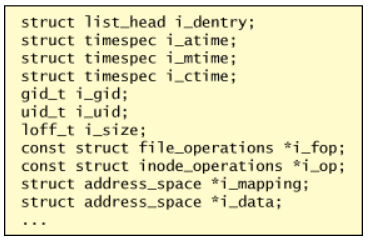

In [ ]:
# @title O que é: https://elixir.bootlin.com/linux/latest/source/include/linux/fs.h#L612
struct inode {
	umode_t			i_mode;
	unsigned short		i_opflags;
	kuid_t			i_uid;
	kgid_t			i_gid;
	unsigned int		i_flags;

#ifdef CONFIG_FS_POSIX_ACL
	struct posix_acl	*i_acl;
	struct posix_acl	*i_default_acl;
#endif

	const struct inode_operations	*i_op;
	struct super_block	*i_sb;
	struct address_space	*i_mapping;

#ifdef CONFIG_SECURITY
	void			*i_security;
#endif

	/* Stat data, not accessed from path walking */
	unsigned long		i_ino;
	/*
	 * Filesystems may only read i_nlink directly.  They shall use the
	 * following functions for modification:
	 *
	 *    (set|clear|inc|drop)_nlink
	 *    inode_(inc|dec)_link_count
	 */
	union {
		const unsigned int i_nlink;
		unsigned int __i_nlink;
	};
	dev_t			i_rdev;
	loff_t			i_size;
	struct timespec64	i_atime;
	struct timespec64	i_mtime;
	struct timespec64	i_ctime;
	spinlock_t		i_lock;	/* i_blocks, i_bytes, maybe i_size */
	unsigned short          i_bytes;
	u8			i_blkbits;
	u8			i_write_hint;
	blkcnt_t		i_blocks;

#ifdef __NEED_I_SIZE_ORDERED
	seqcount_t		i_size_seqcount;
#endif

	/* Misc */
	unsigned long		i_state;
	struct rw_semaphore	i_rwsem;

	unsigned long		dirtied_when;	/* jiffies of first dirtying */
	unsigned long		dirtied_time_when;

	struct hlist_node	i_hash;
	struct list_head	i_io_list;	/* backing dev IO list */
#ifdef CONFIG_CGROUP_WRITEBACK
	struct bdi_writeback	*i_wb;		/* the associated cgroup wb */

	/* foreign inode detection, see wbc_detach_inode() */
	int			i_wb_frn_winner;
	u16			i_wb_frn_avg_time;
	u16			i_wb_frn_history;
#endif
	struct list_head	i_lru;		/* inode LRU list */
	struct list_head	i_sb_list;
	struct list_head	i_wb_list;	/* backing dev writeback list */
	union {
		struct hlist_head	i_dentry;
		struct rcu_head		i_rcu;
	};
	atomic64_t		i_version;
	atomic64_t		i_sequence; /* see futex */
	atomic_t		i_count;
	atomic_t		i_dio_count;
	atomic_t		i_writecount;
#if defined(CONFIG_IMA) || defined(CONFIG_FILE_LOCKING)
	atomic_t		i_readcount; /* struct files open RO */
#endif
	union {
		const struct file_operations	*i_fop;	/* former ->i_op->default_file_ops */
		void (*free_inode)(struct inode *);
	};
	struct file_lock_context	*i_flctx;
	struct address_space	i_data;
	struct list_head	i_devices;
	union {
		struct pipe_inode_info	*i_pipe;
		struct cdev		*i_cdev;
		char			*i_link;
		unsigned		i_dir_seq;
	};

	__u32			i_generation;

#ifdef CONFIG_FSNOTIFY
	__u32			i_fsnotify_mask; /* all events this inode cares about */
	struct fsnotify_mark_connector __rcu	*i_fsnotify_marks;
#endif

#ifdef CONFIG_FS_ENCRYPTION
	struct fscrypt_info	*i_crypt_info;
#endif

#ifdef CONFIG_FS_VERITY
	struct fsverity_info	*i_verity_info;
#endif

	void			*i_private; /* fs or device private pointer */
} __randomize_layout;

In [ ]:
# @title Operações: https://elixir.bootlin.com/linux/latest/source/include/linux/fs.h#L1817
struct inode_operations {
	struct dentry * (*lookup) (struct inode *,struct dentry *, unsigned int);
	const char * (*get_link) (struct dentry *, struct inode *, struct delayed_call *);
	int (*permission) (struct mnt_idmap *, struct inode *, int);
	struct posix_acl * (*get_inode_acl)(struct inode *, int, bool);

	int (*readlink) (struct dentry *, char __user *,int);

	int (*create) (struct mnt_idmap *, struct inode *,struct dentry *,
		       umode_t, bool);
	int (*link) (struct dentry *,struct inode *,struct dentry *);
	int (*unlink) (struct inode *,struct dentry *);
	int (*symlink) (struct mnt_idmap *, struct inode *,struct dentry *,
			const char *);
	int (*mkdir) (struct mnt_idmap *, struct inode *,struct dentry *,
		      umode_t);
	int (*rmdir) (struct inode *,struct dentry *);
	int (*mknod) (struct mnt_idmap *, struct inode *,struct dentry *,
		      umode_t,dev_t);
	int (*rename) (struct mnt_idmap *, struct inode *, struct dentry *,
			struct inode *, struct dentry *, unsigned int);
	int (*setattr) (struct mnt_idmap *, struct dentry *, struct iattr *);
	int (*getattr) (struct mnt_idmap *, const struct path *,
			struct kstat *, u32, unsigned int);
	ssize_t (*listxattr) (struct dentry *, char *, size_t);
	int (*fiemap)(struct inode *, struct fiemap_extent_info *, u64 start,
		      u64 len);
	int (*update_time)(struct inode *, struct timespec64 *, int);
	int (*atomic_open)(struct inode *, struct dentry *,
			   struct file *, unsigned open_flag,
			   umode_t create_mode);
	int (*tmpfile) (struct mnt_idmap *, struct inode *,
			struct file *, umode_t);
	struct posix_acl *(*get_acl)(struct mnt_idmap *, struct dentry *,
				     int);
	int (*set_acl)(struct mnt_idmap *, struct dentry *,
		       struct posix_acl *, int);
	int (*fileattr_set)(struct mnt_idmap *idmap,
			    struct dentry *dentry, struct fileattr *fa);
	int (*fileattr_get)(struct dentry *dentry, struct fileattr *fa);
} ____cacheline_aligned;


## Dentry
A natureza hierárquica do sistema de arquivos é gerida por outro objeto chamado objeto dentry. No sistema de arquivos, há uma única dentry raiz referenciada a partir do superbloco, e esta dentry raiz é a única dentry sem uma camada superior. Todas as outras dentries têm uma camada superior, e algumas delas têm subcamadas. Por exemplo, ao abrir um arquivo estruturado como /home/user/name, são criados quatro objetos dentry (diretório raiz /, entrada home do diretório raiz, entrada do diretório dos usuários e, finalmente, a entrada do nome do usuário). Desta forma, os dentries são claramente mapeados para o sistema de arquivo hierárquico ativo.

A estrutura dentry consiste em vários elementos que rastreiam a relação entre nomes de arquivos, seus itens correspondentes e outros itens. O dentry faz referência ao superbloco que define a instância específica do sistema de arquivos à qual o objeto pertence. Além disso, são definidas as operações dentry (hash, comparar, apagar, liberar, etc.). Depois, é definido o nome do objeto, que é mantido no próprio dentry em vez do inode. Finalmente, é fornecida uma referência ao inode na memória.

O dentry não é um objeto que é guardado em disco, ele só existe na memória do sistema de arquivos. Apenas os inodes do sistema de arquivo são permanentemente guardados no disco, enquanto os dentries são usados para melhora de performance.





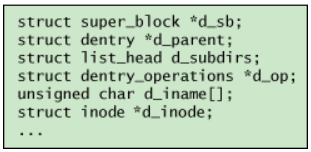

In [ ]:
# @title O que é: https://elixir.bootlin.com/linux/v6.5-rc5/source/include/linux/dcache.h#L82
struct dentry {
	/* RCU lookup touched fields */
	unsigned int d_flags;		/* protected by d_lock */
	seqcount_spinlock_t d_seq;	/* per dentry seqlock */
	struct hlist_bl_node d_hash;	/* lookup hash list */
	struct dentry *d_parent;	/* parent directory */
	struct qstr d_name;
	struct inode *d_inode;		/* Where the name belongs to - NULL is
					 * negative */
	unsigned char d_iname[DNAME_INLINE_LEN];	/* small names */

	/* Ref lookup also touches following */
	struct lockref d_lockref;	/* per-dentry lock and refcount */
	const struct dentry_operations *d_op;
	struct super_block *d_sb;	/* The root of the dentry tree */
	unsigned long d_time;		/* used by d_revalidate */
	void *d_fsdata;			/* fs-specific data */

	union {
		struct list_head d_lru;		/* LRU list */
		wait_queue_head_t *d_wait;	/* in-lookup ones only */
	};
	struct list_head d_child;	/* child of parent list */
	struct list_head d_subdirs;	/* our children */
	/*
	 * d_alias and d_rcu can share memory
	 */
	union {
		struct hlist_node d_alias;	/* inode alias list */
		struct hlist_bl_node d_in_lookup_hash;	/* only for in-lookup ones */
	 	struct rcu_head d_rcu;
	} d_u;
} __randomize_layout;

In [ ]:
# @title Operações: https://elixir.bootlin.com/linux/latest/source/include/linux/dcache.h#L128
struct dentry_operations {
	int (*d_revalidate)(struct dentry *, unsigned int);
	int (*d_weak_revalidate)(struct dentry *, unsigned int);
	int (*d_hash)(const struct dentry *, struct qstr *);
	int (*d_compare)(const struct dentry *,
			unsigned int, const char *, const struct qstr *);
	int (*d_delete)(const struct dentry *);
	int (*d_init)(struct dentry *);
	void (*d_release)(struct dentry *);
	void (*d_prune)(struct dentry *);
	void (*d_iput)(struct dentry *, struct inode *);
	char *(*d_dname)(struct dentry *, char *, int);
	struct vfsmount *(*d_automount)(struct path *);
	int (*d_manage)(const struct path *, bool);
	struct dentry *(*d_real)(struct dentry *, const struct inode *);
} ____cacheline_aligned;

## Context
O contexto do sistema de arquivos, representado pela struct fs_context, é uma estrutura de dados usada na camada do Sistema de Arquivos Virtual (VFS) do kernel Linux para gerenciar a criação, configuração e montagem de um sistema de arquivos. Ele fornece uma maneira de encapsular os parâmetros, opções e informações necessárias para criar ou modificar um superbloco (a estrutura de dados central de um sistema de arquivos) e gerenciar o processo de montagem. O contexto do sistema de arquivos permite a separação de informações específicas do sistema de arquivos do resto das operações VFS, permitindo que diferentes tipos de sistemas de arquivos sejam tratados uniformemente pela camada VFS.

o que é: https://elixir.bootlin.com/linux/latest/source/include/linux/fs_context.h#L90

Documentacao: https://elixir.bootlin.com/linux/latest/source/Documentation/filesystems/mount_api.rst#L61

operações (link do prof): https://elixir.bootlin.com/linux/latest/source/include/linux/fs_context.h#L114



## File
Um objeto file não corresponde a um dado salvo em disco, ele é, na verdade, uma abstração que representa um arquivo que foi aberto por um processo, representando esse arquivo carregado em memória.

Em geral, o objeto file está aberto e referenciado na lista de descritores de arquivos do processo. O objeto file faz referência ao objeto dentry, e o objeto dentry faz referência ao inode e este, por sua vez, representa o arquivo na memória (conjunto de blocos ocupados por esse arquivos na memória). Ambos os objetos inode e dentry referenciam o superblock subjacente.

Vários objetos file também podem fazer referência ao mesmo dentry, como quando dois usuários compartilham arquivos. Além disso, os objetos dentry podem fazer referência a outros objetos dentry.

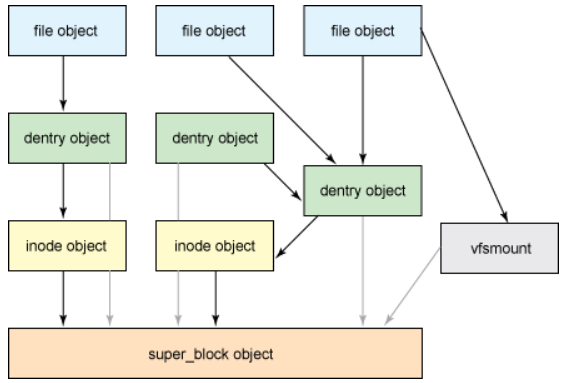

In [ ]:
# @title O que é: https://elixir.bootlin.com/linux/latest/source/include/linux/fs.h#L959
struct file {
	union {
		struct llist_node	f_llist;
		struct rcu_head 	f_rcuhead;
		unsigned int 		f_iocb_flags;
	};
	struct path		f_path;
	struct inode		*f_inode;	/* cached value */
	const struct file_operations	*f_op;

	/*
	 * Protects f_ep, f_flags.
	 * Must not be taken from IRQ context.
	 */
	spinlock_t		f_lock;
	atomic_long_t		f_count;
	unsigned int 		f_flags;
	fmode_t			f_mode;
	struct mutex		f_pos_lock;
	loff_t			f_pos;
	struct fown_struct	f_owner;
	const struct cred	*f_cred;
	struct file_ra_state	f_ra;

	u64			f_version;
#ifdef CONFIG_SECURITY
	void			*f_security;
#endif
	/* needed for tty driver, and maybe others */
	void			*private_data;

#ifdef CONFIG_EPOLL
	/* Used by fs/eventpoll.c to link all the hooks to this file */
	struct hlist_head	*f_ep;
#endif /* #ifdef CONFIG_EPOLL */
	struct address_space	*f_mapping;
	errseq_t		f_wb_err;
	errseq_t		f_sb_err; /* for syncfs */
} __randomize_layout
  __attribute__((aligned(4)));	/* lest something weird decides that 2 is OK */

In [ ]:
# @title Operações: https://elixir.bootlin.com/linux/latest/source/include/linux/fs.h#L1771

struct file_operations {
	struct module *owner;
	loff_t (*llseek) (struct file *, loff_t, int);
	ssize_t (*read) (struct file *, char __user *, size_t, loff_t *);
	ssize_t (*write) (struct file *, const char __user *, size_t, loff_t *);
	ssize_t (*read_iter) (struct kiocb *, struct iov_iter *);
	ssize_t (*write_iter) (struct kiocb *, struct iov_iter *);
	int (*iopoll)(struct kiocb *kiocb, struct io_comp_batch *,
			unsigned int flags);
	int (*iterate) (struct file *, struct dir_context *);
	int (*iterate_shared) (struct file *, struct dir_context *);
	__poll_t (*poll) (struct file *, struct poll_table_struct *);
	long (*unlocked_ioctl) (struct file *, unsigned int, unsigned long);
	long (*compat_ioctl) (struct file *, unsigned int, unsigned long);
	int (*mmap) (struct file *, struct vm_area_struct *);
	unsigned long mmap_supported_flags;
	int (*open) (struct inode *, struct file *);
	int (*flush) (struct file *, fl_owner_t id);
	int (*release) (struct inode *, struct file *);
	int (*fsync) (struct file *, loff_t, loff_t, int datasync);
	int (*fasync) (int, struct file *, int);
	int (*lock) (struct file *, int, struct file_lock *);
	ssize_t (*sendpage) (struct file *, struct page *, int, size_t, loff_t *, int);
	unsigned long (*get_unmapped_area)(struct file *, unsigned long, unsigned long, unsigned long, unsigned long);
	int (*check_flags)(int);
	int (*flock) (struct file *, int, struct file_lock *);
	ssize_t (*splice_write)(struct pipe_inode_info *, struct file *, loff_t *, size_t, unsigned int);
	ssize_t (*splice_read)(struct file *, loff_t *, struct pipe_inode_info *, size_t, unsigned int);
	int (*setlease)(struct file *, long, struct file_lock **, void **);
	long (*fallocate)(struct file *file, int mode, loff_t offset,
			  loff_t len);
	void (*show_fdinfo)(struct seq_file *m, struct file *f);
#ifndef CONFIG_MMU
	unsigned (*mmap_capabilities)(struct file *);
#endif
	ssize_t (*copy_file_range)(struct file *, loff_t, struct file *,
			loff_t, size_t, unsigned int);
	loff_t (*remap_file_range)(struct file *file_in, loff_t pos_in,
				   struct file *file_out, loff_t pos_out,
				   loff_t len, unsigned int remap_flags);
	int (*fadvise)(struct file *, loff_t, loff_t, int);
	int (*uring_cmd)(struct io_uring_cmd *ioucmd, unsigned int issue_flags);
	int (*uring_cmd_iopoll)(struct io_uring_cmd *, struct io_comp_batch *,
				unsigned int poll_flags);
} __randomize_layout;

# Suporte para os Sistemas de Arquivos

## Register
https://elixir.bootlin.com/linux/latest/source/fs/filesystems.c#L72

Para o registro de um novo sistema de arquivos é utilizado o método register_filesystem:
```
int register_filesystem(struct file_system_type * fs)
{
	int res = 0;
	struct file_system_type ** p;

	if (fs->parameters &&
	    !fs_validate_description(fs->name, fs->parameters))
		return -EINVAL;

	BUG_ON(strchr(fs->name, '.'));
	if (fs->next)
		return -EBUSY;
	write_lock(&file_systems_lock);
	p = find_filesystem(fs->name, strlen(fs->name));
	if (*p)
		res = -EBUSY;
	else
		*p = fs;
	write_unlock(&file_systems_lock);
	return res;
}
```
O método acima faz uma checagem nos sistemas de arquivos registrados antes de prosseguir com o registro do novo, isso porquê, caso o sistema recebido por parâmetro já tenha sido registrado, não pode ocorrer um registro duplo e, com isso, a função retorna -EBUSY. Caso o sistema não tenha sido registrado ainda, a função find_file_system retorna NULL, que na verdade é um ponteiro para a primeira posição livre na lista de sistemas de arquivos, e atribui à essa posição o novo sistema de arquivos e, com isso, ele está registrado no sistema.

O método register_file_system recebe como parâmetro um ponteiro para a struct file_system_type que contém as informações relevantes para o VFS sobre esse sistema de arquivos juntamente com seu conjunto de funções e o que elas representam.
```
 struct file_system_type {
         const char *name;
         int fs_flags;
 #define FS_REQUIRES_DEV         1
 #define FS_BINARY_MOUNTDATA     2
 #define FS_HAS_SUBTYPE          4
 #define FS_USERNS_MOUNT         8       /* Can be mounted by userns root */
 #define FS_RENAME_DOES_D_MOVE   32768   /* FS will handle d_move() during rename() internally. */
         struct dentry *(*mount) (struct file_system_type *, int,
                    const char *, void *);
         void (*kill_sb) (struct super_block *);
         struct module *owner;                    /* module */
         struct file_system_type * next;
         struct hlist_head fs_supers;

         struct lock_class_key s_lock_key;
         struct lock_class_key s_umount_key;
         struct lock_class_key s_vfs_rename_key;
         struct lock_class_key s_writers_key[SB_FREEZE_LEVELS];

         struct lock_class_key i_lock_key;
         struct lock_class_key i_mutex_key;
         struct lock_class_key i_mutex_dir_key;
 };
```
As funções do novo sistema de arquivos, sobrescrevem as funções contidas na struct file_operations, essa sobrescrição acontece no arquivo .h de cada sistema de arquivos.
```
struct file_operations {
	struct module *owner;
	loff_t (*llseek) (struct file *, loff_t, int);
	ssize_t (*read) (struct file *, char __user *, size_t, loff_t *);
	ssize_t (*write) (struct file *, const char __user *, size_t, loff_t *);
	ssize_t (*read_iter) (struct kiocb *, struct iov_iter *);
	ssize_t (*write_iter) (struct kiocb *, struct iov_iter *);
	int (*iopoll)(struct kiocb *kiocb, struct io_comp_batch *,
			unsigned int flags);
	int (*iterate) (struct file *, struct dir_context *);
	int (*iterate_shared) (struct file *, struct dir_context *);
	__poll_t (*poll) (struct file *, struct poll_table_struct *);
	long (*unlocked_ioctl) (struct file *, unsigned int, unsigned long);
	long (*compat_ioctl) (struct file *, unsigned int, unsigned long);
	int (*mmap) (struct file *, struct vm_area_struct *);
	unsigned long mmap_supported_flags;
	int (*open) (struct inode *, struct file *);
	int (*flush) (struct file *, fl_owner_t id);
	int (*release) (struct inode *, struct file *);
	int (*fsync) (struct file *, loff_t, loff_t, int datasync);
	int (*fasync) (int, struct file *, int);
	int (*lock) (struct file *, int, struct file_lock *);
	ssize_t (*sendpage) (struct file *, struct page *, int, size_t, loff_t *, int);
	unsigned long (*get_unmapped_area)(struct file *, unsigned long, unsigned long, unsigned long, unsigned long);
	int (*check_flags)(int);
	int (*flock) (struct file *, int, struct file_lock *);
	ssize_t (*splice_write)(struct pipe_inode_info *, struct file *, loff_t *, size_t, unsigned int);
	ssize_t (*splice_read)(struct file *, loff_t *, struct pipe_inode_info *, size_t, unsigned int);
	int (*setlease)(struct file *, long, struct file_lock **, void **);
	long (*fallocate)(struct file *file, int mode, loff_t offset,
			  loff_t len);
	void (*show_fdinfo)(struct seq_file *m, struct file *f);
#ifndef CONFIG_MMU
	unsigned (*mmap_capabilities)(struct file *);
#endif
	ssize_t (*copy_file_range)(struct file *, loff_t, struct file *,
			loff_t, size_t, unsigned int);
	loff_t (*remap_file_range)(struct file *file_in, loff_t pos_in,
				   struct file *file_out, loff_t pos_out,
				   loff_t len, unsigned int remap_flags);
	int (*fadvise)(struct file *, loff_t, loff_t, int);
	int (*uring_cmd)(struct io_uring_cmd *ioucmd, unsigned int issue_flags);
	int (*uring_cmd_iopoll)(struct io_uring_cmd *, struct io_comp_batch *,
				unsigned int poll_flags);
} __randomize_layout;
```


Para exemplo disso, temos o tipo sistema de arquivos ext2, no arquivo ext2.h, são definidas structs do tipo file_operation para diretórios (ext2_dir_operations) e arquivos (ext2_file_operations), essas variáveis são utilizadas no arquivo inode.c nos métodos ext2_set_file_ops e ext2_iget, os quais fazem a atribuição dessas operações próprias do ext2 para o atributo i_fop do inode do arquivo desse sistema de arquivos. Além das operações do sistema de arquivos, nesse método ext2_set_file_ops o atributo i_op do inode (operações do i_node) também é atualizado para as funções do inode do arquivo pertecente ao ext2.
```
void ext2_set_file_ops(struct inode *inode)
{
	inode->i_op = &ext2_file_inode_operations;
	inode->i_fop = &ext2_file_operations;
	if (IS_DAX(inode))
		inode->i_mapping->a_ops = &ext2_dax_aops;
	else
		inode->i_mapping->a_ops = &ext2_aops;
}
```
E como a função de registro de um sistema de arquivos novo sabe qual esse sistema e suas funções?

Cada sistema de arquivos possui uma função inicializadora, no caso do ext2, init_ext2_fs, essa função chama a register_file_system passando como parâmetro o endereço para uma struct file_system_type que contém as informações e funções do sistema de arquivos ext2 a ser registrado.
```
static int __init init_ext2_fs(void)
{
	int err;

	err = init_inodecache();
	if (err)
		return err;
	err = register_filesystem(&ext2_fs_type);
	if (err)
		goto out;
	return 0;
out:
	destroy_inodecache();
	return err;
}
```
Ou seja, quando a struct file_system_type é preenchida com informações do ext2 (ext2_fs_type), o campo mount que recebe o retorno da função ext2_mount, função essa que é responsável por, através de uma série de passos e verificações, fazer a substituição das função da struct file_operations pelas funções do novo sistema de arquivos a ser registrado (ou que pelo menos tentará ser registrado já que essa verificação só ocorre após toda a declaração ter terminado).
```
static struct file_system_type ext2_fs_type = {
	.owner		= THIS_MODULE,
	.name		= "ext2",
	.mount		= ext2_mount,
	.kill_sb	= kill_block_super,
	.fs_flags	= FS_REQUIRES_DEV,
};
```

## Unregister
https://elixir.bootlin.com/linux/v6.4.11/source/fs/filesystems.c#L108
E em qual situações devemos remover algum sistema de arquivos registrado? E como fazemos isso?

Quando o módulo de implementação de um sistema de arquivos é descarregado ou quando esse sistema é desligado, faz-se necessária a remoção desse sistema de arquivos do registro de sistemas suportados. Para isso, utilizamos a função unregister_filesystem que recebe como parâmetro um ponteiro para a struct desse sistema de arquivos e, com isso, percorre a lista encadeada de sistemas de arquivos registrados até encontrar. Caso encontre, é realizada a remoção nessa lista (sobrescreve o ponteiro do registro a ser removido com o registro da frente), tira a referência "next" do registro a ser removido e retorna 0, caso não encontre, retorna um erro (-EINVAL).
```
int unregister_filesystem(struct file_system_type * fs)
{
	struct file_system_type ** tmp;

	write_lock(&file_systems_lock);
	tmp = &file_systems;
	while (*tmp) {
		if (fs == *tmp) {
			*tmp = fs->next;
			fs->next = NULL;
			write_unlock(&file_systems_lock);
			synchronize_rcu();
			return 0;
		}
		tmp = &(*tmp)->next;
	}
	write_unlock(&file_systems_lock);

	return -EINVAL;
}
```

#Montagem do Sistema de Arquivos

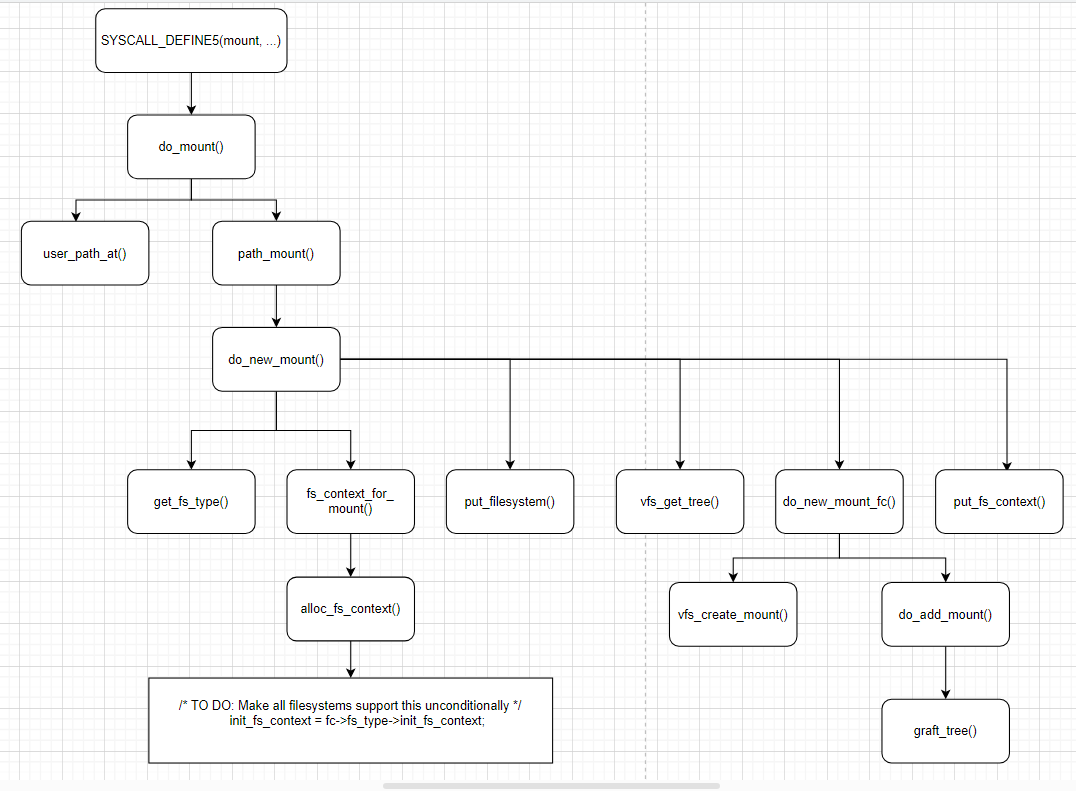

In [ ]:
# @title mount
# @markdown A função mount() do sistema é usada para montar o Sistema de Arquivos Virtual (VFS), e sua rotina opera nos seguintes argumentos:

# @markdown Source: Indica o caminho de um arquivo de dispositivo que contém o sistema de arquivos, ou NULL se for um sistema de arquivos baseado em rede.

# @markdown target: Aponta para o caminho do diretório onde o sistema de arquivos será montado.

# @markdown filesystemtype: Define o tipo do sistema de arquivos, que deve ser um nome de sistema de arquivos já registrado.

# @markdown mountflags: Define as opções de montagem.

# @markdown data: Refere-se a uma estrutura de dados específica do sistema de arquivos (pode ser nulo).
int mount(const char *source, const char *target,
          const char *filesystemtype, unsigned long mountflags,
          const void *data);

In [ ]:
# @title Syscall mount
# @markdown A função encapsula o tratamento da chamada de sistema mount, concebida para facilitar a montagem de sistemas de arquivos em diretórios. Ela gerencia a cópia de parâmetros do espaço do utilizador para a memória do espaço do kernel, efetua potenciais conversões nas opções de montagem com base no tipo de sistema de arquivos e, subsequentemente, chama a função do_mount para encontrar o ponto de montagem.
COMPAT_SYSCALL_DEFINE5(mount, const char __user *, dev_name,
		       const char __user *, dir_name,
		       const char __user *, type, compat_ulong_t, flags,
		       const void __user *, data)
{
	char *kernel_type;
	void *options;
	char *kernel_dev;
	int retval;

	kernel_type = copy_mount_string(type);
	retval = PTR_ERR(kernel_type);
	if (IS_ERR(kernel_type))
		goto out;

	kernel_dev = copy_mount_string(dev_name);
	retval = PTR_ERR(kernel_dev);
	if (IS_ERR(kernel_dev))
		goto out1;

	options = copy_mount_options(data);
	retval = PTR_ERR(options);
	if (IS_ERR(options))
		goto out2;

	if (kernel_type && options) {
		if (!strcmp(kernel_type, NCPFS_NAME)) {
			do_ncp_super_data_conv(options);
		} else if (!strcmp(kernel_type, NFS4_NAME)) {
			retval = -EINVAL;
			if (do_nfs4_super_data_conv(options))
				goto out3;
		}
	}

	retval = do_mount(kernel_dev, dir_name, kernel_type, flags, options);

 out3:
	kfree(options);
 out2:
	kfree(kernel_dev);
 out1:
	kfree(kernel_type);
 out:
	return retval;
}

In [ ]:
# @title do_mount
# @markdown A função do_mount recupera um caminho do sistema de arquivos para o diretório de destino usando a função user_path_at, então prossegue para montar o sistema de arquivos usando o caminho recuperado e outros parâmetros de entrada chamando path_mount

long do_mount(const char *dev_name, const char __user *dir_name,
		const char *type_page, unsigned long flags, void *data_page)
{
	struct path path;
	int ret;

	ret = user_path_at(AT_FDCWD, dir_name, LOOKUP_FOLLOW, &path);
	if (ret)
		return ret;
	ret = path_mount(dev_name, &path, type_page, flags, data_page);
	path_put(&path);
	return ret;
}


In [ ]:
# @title path_mount
# @markdown A função trata de operações de montagem em diretórios processando sinalizadores, gerenciando comportamentos padrão e validando permissões. A função verifica as flags, elimina valores mágicos, define opções predefinidas e trata de cenários de montagem específicos, como remontagem e ligação. Garante a segurança e as verificações de permissões desencadeia ações relevantes com base nas flags fornecidas e procede chamando a função de_new_mount

int path_mount(const char *dev_name, struct path *path,
		const char *type_page, unsigned long flags, void *data_page)
{
	unsigned int mnt_flags = 0, sb_flags;
	int ret;

	/* Discard magic */
	if ((flags & MS_MGC_MSK) == MS_MGC_VAL)
		flags &= ~MS_MGC_MSK;

	/* Basic sanity checks */
	if (data_page)
		((char *)data_page)[PAGE_SIZE - 1] = 0;

	if (flags & MS_NOUSER)
		return -EINVAL;

	ret = security_sb_mount(dev_name, path, type_page, flags, data_page);
	if (ret)
		return ret;
	if (!may_mount())
		return -EPERM;
	if (flags & SB_MANDLOCK)
		warn_mandlock();

	/* Default to relatime unless overriden */
	if (!(flags & MS_NOATIME))
		mnt_flags |= MNT_RELATIME;

	/* Separate the per-mountpoint flags */
	if (flags & MS_NOSUID)
		mnt_flags |= MNT_NOSUID;
	if (flags & MS_NODEV)
		mnt_flags |= MNT_NODEV;
	if (flags & MS_NOEXEC)
		mnt_flags |= MNT_NOEXEC;
	if (flags & MS_NOATIME)
		mnt_flags |= MNT_NOATIME;
	if (flags & MS_NODIRATIME)
		mnt_flags |= MNT_NODIRATIME;
	if (flags & MS_STRICTATIME)
		mnt_flags &= ~(MNT_RELATIME | MNT_NOATIME);
	if (flags & MS_RDONLY)
		mnt_flags |= MNT_READONLY;
	if (flags & MS_NOSYMFOLLOW)
		mnt_flags |= MNT_NOSYMFOLLOW;

	/* The default atime for remount is preservation */
	if ((flags & MS_REMOUNT) &&
	    ((flags & (MS_NOATIME | MS_NODIRATIME | MS_RELATIME |
		       MS_STRICTATIME)) == 0)) {
		mnt_flags &= ~MNT_ATIME_MASK;
		mnt_flags |= path->mnt->mnt_flags & MNT_ATIME_MASK;
	}

	sb_flags = flags & (SB_RDONLY |
			    SB_SYNCHRONOUS |
			    SB_MANDLOCK |
			    SB_DIRSYNC |
			    SB_SILENT |
			    SB_POSIXACL |
			    SB_LAZYTIME |
			    SB_I_VERSION);

	if ((flags & (MS_REMOUNT | MS_BIND)) == (MS_REMOUNT | MS_BIND))
		return do_reconfigure_mnt(path, mnt_flags);
	if (flags & MS_REMOUNT)
		return do_remount(path, flags, sb_flags, mnt_flags, data_page);
	if (flags & MS_BIND)
		return do_loopback(path, dev_name, flags & MS_REC);
	if (flags & (MS_SHARED | MS_PRIVATE | MS_SLAVE | MS_UNBINDABLE))
		return do_change_type(path, flags);
	if (flags & MS_MOVE)
		return do_move_mount_old(path, dev_name);

	return do_new_mount(path, type_page, sb_flags, mnt_flags, dev_name,
			    data_page);
}
```

https://elixir.bootlin.com/linux/latest/source/init/do_mounts.c#L566

https://elixir.bootlin.com/linux/v6.5-rc5/source/include/linux/mount.h#L70

**O "vfsmount" Representa o sistema de Arquivos Montado**
```
struct vfsmount {
	struct dentry *mnt_root;	/* root of the mounted tree */
	struct super_block *mnt_sb;	/* pointer to superblock */
	int mnt_flags;
	struct mnt_idmap *mnt_idmap;
} __randomize_layout;
```
https://elixir.bootlin.com/linux/v6.5-rc5/source/security/inode.c#L25
```
static struct vfsmount *mount;


In [ ]:
# @title do_new_mount
# @markdown A função do_new_mount() utiliza a função get_fs_type(), que após percorrer a lista de sistemas de arquivo registrados, retorna um file_system_type. Feito isso, é chamada a função fs_context_for_mount e depois de validado se a função fs_context_for_mount foi executada com sucesso é chamada a função do_new_mount_fc(), que adiciona esse ponto de montagem na hierarquia do sistema de arquivos;

static int do_new_mount(struct path *path, const char *fstype, int sb_flags,
			int mnt_flags, const char *name, void *data)
{
	struct file_system_type *type;
	struct fs_context *fc;
	const char *subtype = NULL;
	int err = 0;

	if (!fstype)
		return -EINVAL;

	type = get_fs_type(fstype);
	if (!type)
		return -ENODEV;

	if (type->fs_flags & FS_HAS_SUBTYPE) {
		subtype = strchr(fstype, '.');
		if (subtype) {
			subtype++;
			if (!*subtype) {
				put_filesystem(type);
				return -EINVAL;
			}
		}
	}

	fc = fs_context_for_mount(type, sb_flags);
	put_filesystem(type);
	if (IS_ERR(fc))
		return PTR_ERR(fc);

	if (subtype)
		err = vfs_parse_fs_string(fc, "subtype",
					  subtype, strlen(subtype));
	if (!err && name)
		err = vfs_parse_fs_string(fc, "source", name, strlen(name));
	if (!err)
		err = parse_monolithic_mount_data(fc, data);
	if (!err && !mount_capable(fc))
		err = -EPERM;
	if (!err)
		err = vfs_get_tree(fc);
	if (!err)
		err = do_new_mount_fc(fc, path, mnt_flags);

	put_fs_context(fc);
	return err;
}


In [ ]:
# @title put_fs_context
# @markdown chama a função alloc_fs_context
struct fs_context *fs_context_for_mount(struct file_system_type *fs_type,
					unsigned int sb_flags)
{
	return alloc_fs_context(fs_type, NULL, sb_flags, 0,
					FS_CONTEXT_FOR_MOUNT);
}

In [ ]:
# @title alloc_fs_context
# @markdown a função alloc_fs_context é responsável pela atribuição e inicialização de um contexto de sistema de arquivos (struct fs_context). A função inicializa vários campos dentro do contexto, como finalidade, tags, tipo de sistema de arquivos, credenciais, espaço de nomes de rede, entre outros. Em seguida, chama a função init_fs_context apropriada, a partir do tipo de sistema de arquivos ou de uma função herdada, para configurar ainda mais o contexto.

3static struct fs_context *alloc_fs_context(struct file_system_type *fs_type,
				      struct dentry *reference,
				      unsigned int sb_flags,
				      unsigned int sb_flags_mask,
				      enum fs_context_purpose purpose)
{
	int (*init_fs_context)(struct fs_context *);
	struct fs_context *fc;
	int ret = -ENOMEM;

	fc = kzalloc(sizeof(struct fs_context), GFP_KERNEL_ACCOUNT);
	if (!fc)
		return ERR_PTR(-ENOMEM);

	fc->purpose	= purpose;
	fc->sb_flags	= sb_flags;
	fc->sb_flags_mask = sb_flags_mask;
	fc->fs_type	= get_filesystem(fs_type);
	fc->cred	= get_current_cred();
	fc->net_ns	= get_net(current->nsproxy->net_ns);
	fc->log.prefix	= fs_type->name;

	mutex_init(&fc->uapi_mutex);

	switch (purpose) {
	case FS_CONTEXT_FOR_MOUNT:
		fc->user_ns = get_user_ns(fc->cred->user_ns);
		break;
	case FS_CONTEXT_FOR_SUBMOUNT:
		fc->user_ns = get_user_ns(reference->d_sb->s_user_ns);
		break;
	case FS_CONTEXT_FOR_RECONFIGURE:
		atomic_inc(&reference->d_sb->s_active);
		fc->user_ns = get_user_ns(reference->d_sb->s_user_ns);
		fc->root = dget(reference);
		break;
	}

	/* TODO: Make all filesystems support this unconditionally */
	init_fs_context = fc->fs_type->init_fs_context;
	if (!init_fs_context)
		init_fs_context = legacy_init_fs_context;

	ret = init_fs_context(fc);
	if (ret < 0)
		goto err_fc;
	fc->need_free = true;
	return fc;

err_fc:
	put_fs_context(fc);
	return ERR_PTR(ret);
}

# Chamadas de Sistema

##open


In [ ]:
# @title Syscall open
# @markdown A implementação da chamada de sistema open no kernel Linux é responsável por abrir ou criar arquivos dentro de um sistema de arquivos. Recebe argumentos para o nome do arquivo, flags indicando como o arquivo deve ser acessado e permissões se um novo arquivo estiver a ser criado.Finalmente, chama a função do_sys_open para executar a operação de arquivo.

SYSCALL_DEFINE3(open, const char __user *, filename, int, flags, umode_t, mode)
{
	if (force_o_largefile())
		flags |= O_LARGEFILE;
	return do_sys_open(AT_FDCWD, filename, flags, mode);
}

In [ ]:
#@title do_sys_open
#@markdown Essa função constrói uma estrutura open_how baseada nos flags e no modo fornecidos, e então invoca a função do_sys_openat2 com o descritor de arquivo do diretório, o nome do arquivo e a estrutura construída.
static long do_sys_openat2(int dfd, const char __user *filename,
			   struct open_how *how)
{
	struct open_flags op;
	int fd = build_open_flags(how, &op);
	struct filename *tmp;

	if (fd)
		return fd;

	tmp = getname(filename);
	if (IS_ERR(tmp))
		return PTR_ERR(tmp);

	fd = get_unused_fd_flags(how->flags);
	if (fd >= 0) {
		struct file *f = do_filp_open(dfd, tmp, &op);
		if (IS_ERR(f)) {
			put_unused_fd(fd);
			fd = PTR_ERR(f);
		} else {
			fsnotify_open(f);
			fd_install(fd, f);
		}
	}
	putname(tmp);
	return fd;
}

In [ ]:
#@title do_sys_openat2
#@markdown Essa função recebe parâmetros que representam um descritor de arquivo de diretório (dfd), um ponteiro no espaço do usuário para um nome de arquivo (filename) e a estrutura open_how. Essa função traduz a estrutura open_how em flags de abertura internos (op) e usa o diretório e o nome de arquivo fornecidos para criar e inicializar um novo objeto de arquivo, feito pela função do_filp_open(). Essa função facilita a abertura do arquivo com os parâmetros especificados, tratando possíveis erros e retornando o descritor de arquivo do arquivo aberto ou um código de erro.

static long do_sys_openat2(int dfd, const char __user *filename,
			   struct open_how *how)
{
	struct open_flags op;
	int fd = build_open_flags(how, &op);
	struct filename *tmp;

	if (fd)
		return fd;

	tmp = getname(filename);
	if (IS_ERR(tmp))
		return PTR_ERR(tmp);

	fd = get_unused_fd_flags(how->flags);
	if (fd >= 0) {
		struct file *f = do_filp_open(dfd, tmp, &op);
		if (IS_ERR(f)) {
			put_unused_fd(fd);
			fd = PTR_ERR(f);
		} else {
			fsnotify_open(f);
			fd_install(fd, f);
		}
	}
	putname(tmp);
	return fd;
}

In [ ]:
#@title do_filp_open
#@markdown A função usa as informações fornecidas para abrir o arquivo especificado usando a função path_openat, considerando os flags de pesquisa e os mecanismos de RCU. Em caso de determinados erros, ela tenta novamente abrir o arquivo com flags alternativos. A função retorna um ponteiro para o arquivo aberto (struct file) ou um código de erro.
struct file *do_filp_open(int dfd, struct filename *pathname,
		const struct open_flags *op)
{
	struct nameidata nd;
	int flags = op->lookup_flags;
	struct file *filp;

	set_nameidata(&nd, dfd, pathname, NULL);
	filp = path_openat(&nd, op, flags | LOOKUP_RCU);
	if (unlikely(filp == ERR_PTR(-ECHILD)))
		filp = path_openat(&nd, op, flags);
	if (unlikely(filp == ERR_PTR(-ESTALE)))
		filp = path_openat(&nd, op, flags | LOOKUP_REVAL);
	restore_nameidata();
	return filp;
}


In [ ]:
#@title path_openat
#@markdown A função aloca uma estrutura de arquivo vazia com base nos flags de abertura fornecidos e nas permissões do grupo e do usuário do processo atual.A função inicializa a estrutura nameidata e executa o caminho do link para percorrer os componentes do caminho. Se for bem-sucedido, ele executa a abertura do_open(). Após essas etapas, ele verifica se há erros e retorna a estrutura do arquivo aberto se for bem-sucedido. Se ocorrer um erro, ele libera os recursos alocados e retorna um código de erro ou um ponteiro de erro apropriado.
static struct file *path_openat(struct nameidata *nd,
			const struct open_flags *op, unsigned flags)
{
	struct file *file;
	int error;

	file = alloc_empty_file(op->open_flag, current_cred());
	if (IS_ERR(file))
		return file;

	if (unlikely(file->f_flags & __O_TMPFILE)) {
		error = do_tmpfile(nd, flags, op, file);
	} else if (unlikely(file->f_flags & O_PATH)) {
		error = do_o_path(nd, flags, file);
	} else {
		const char *s = path_init(nd, flags);
		while (!(error = link_path_walk(s, nd)) &&
		       (s = open_last_lookups(nd, file, op)) != NULL)
			;
		if (!error)
			error = do_open(nd, file, op);
		terminate_walk(nd);
	}
	if (likely(!error)) {
		if (likely(file->f_mode & FMODE_OPENED))
			return file;
		WARN_ON(1);
		error = -EINVAL;
	}
	fput(file);
	if (error == -EOPENSTALE) {
		if (flags & LOOKUP_RCU)
			error = -ECHILD;
		else
			error = -ESTALE;
	}
	return ERR_PTR(error);
}

In [ ]:
#@title do_open
#@markdown A função executa verificações para garantir a abertura adequada de arquivos e o tratamento de permissões, incluindo a conclusão da passagem do caminho, a realização de auditorias, o tratamento da criação de arquivos, a verificação da pesquisa de diretório, o truncamento e as permissões. Ele também faz interface com outras funções, como vfs_open e ima_file_check, para garantir a integridade do arquivo e a conformidade do acesso. Em caso de erros durante o processo, os códigos de erro respectivos são retornados

static int do_open(struct nameidata *nd,
		   struct file *file, const struct open_flags *op)
{
	struct mnt_idmap *idmap;
	int open_flag = op->open_flag;
	bool do_truncate;
	int acc_mode;
	int error;

	if (!(file->f_mode & (FMODE_OPENED | FMODE_CREATED))) {
		error = complete_walk(nd);
		if (error)
			return error;
	}
	if (!(file->f_mode & FMODE_CREATED))
		audit_inode(nd->name, nd->path.dentry, 0);
	idmap = mnt_idmap(nd->path.mnt);
	if (open_flag & O_CREAT) {
		if ((open_flag & O_EXCL) && !(file->f_mode & FMODE_CREATED))
			return -EEXIST;
		if (d_is_dir(nd->path.dentry))
			return -EISDIR;
		error = may_create_in_sticky(idmap, nd,
					     d_backing_inode(nd->path.dentry));
		if (unlikely(error))
			return error;
	}
	if ((nd->flags & LOOKUP_DIRECTORY) && !d_can_lookup(nd->path.dentry))
		return -ENOTDIR;

	do_truncate = false;
	acc_mode = op->acc_mode;
	if (file->f_mode & FMODE_CREATED) {
		/* Don't check for write permission, don't truncate */
		open_flag &= ~O_TRUNC;
		acc_mode = 0;
	} else if (d_is_reg(nd->path.dentry) && open_flag & O_TRUNC) {
		error = mnt_want_write(nd->path.mnt);
		if (error)
			return error;
		do_truncate = true;
	}
	error = may_open(idmap, &nd->path, acc_mode, open_flag);
	if (!error && !(file->f_mode & FMODE_OPENED))
		error = vfs_open(&nd->path, file);
	if (!error)
		error = ima_file_check(file, op->acc_mode);
	if (!error && do_truncate)
		error = handle_truncate(idmap, file);
	if (unlikely(error > 0)) {
		WARN_ON(1);
		error = -EINVAL;
	}
	if (do_truncate)
		mnt_drop_write(nd->path.mnt);
	return error;
}

In [ ]:
#@title vfs_open
#@markdown A função vfs_open é responsável por abrir um arquivo usando a camada VFS no kernel do Linux.A função recebe um caminho e uma estrutura de arquivo como entrada e define o caminho do arquivo como o caminho fornecido e, em seguida, chama do_dentry_open para iniciar o processo de abertura do arquivo. Essa função estabelece efetivamente uma conexão entre a estrutura do arquivo e o inode associado ao caminho fornecido, permitindo que as operações subsequentes no arquivo sejam realizadas por meio da camada VFS.

int vfs_open(const struct path *path, struct file *file)
{
	file->f_path = *path;
	return do_dentry_open(file, d_backing_inode(path->dentry), NULL);
}

In [ ]:
#@title dentry_open
#@markdown A função do_dentry_open é responsável pelo processo principal de abertura de um arquivo após a conclusão da resolução do caminho. Ela configura vários atributos e operações para a estrutura do arquivo, incluindo o inode associado e as operações do arquivo.Ele lida com vários casos, como acesso de leitura e gravação, verificação de permissões e inicialização do estado de leitura antecipada.A função garante que o arquivo esteja devidamente preparado para operações de E/S, incluindo o tratamento de E/S direta e a limpeza de determinados flags de arquivo. Se ocorrer algum erro durante o processo, serão executadas as etapas de limpeza apropriadas para liberar recursos e lidar com possíveis erros.

static int do_dentry_open(struct file *f,
			  struct inode *inode,
			  int (*open)(struct inode *, struct file *))
{
	static const struct file_operations empty_fops = {};
	int error;

	path_get(&f->f_path);
	f->f_inode = inode;
	f->f_mapping = inode->i_mapping;
	f->f_wb_err = filemap_sample_wb_err(f->f_mapping);
	f->f_sb_err = file_sample_sb_err(f);

	if (unlikely(f->f_flags & O_PATH)) {
		f->f_mode = FMODE_PATH | FMODE_OPENED;
		f->f_op = &empty_fops;
		return 0;
	}

	if ((f->f_mode & (FMODE_READ | FMODE_WRITE)) == FMODE_READ) {
		i_readcount_inc(inode);
	} else if (f->f_mode & FMODE_WRITE && !special_file(inode->i_mode)) {
		error = get_write_access(inode);
		if (unlikely(error))
			goto cleanup_file;
		error = __mnt_want_write(f->f_path.mnt);
		if (unlikely(error)) {
			put_write_access(inode);
			goto cleanup_file;
		}
		f->f_mode |= FMODE_WRITER;
	}

	/* POSIX.1-2008/SUSv4 Section XSI 2.9.7 */
	if (S_ISREG(inode->i_mode) || S_ISDIR(inode->i_mode))
		f->f_mode |= FMODE_ATOMIC_POS;

	f->f_op = fops_get(inode->i_fop);
	if (WARN_ON(!f->f_op)) {
		error = -ENODEV;
		goto cleanup_all;
	}

	error = security_file_open(f);
	if (error)
		goto cleanup_all;

	error = break_lease(file_inode(f), f->f_flags);
	if (error)
		goto cleanup_all;

	/* normally all 3 are set; ->open() can clear them if needed */
	f->f_mode |= FMODE_LSEEK | FMODE_PREAD | FMODE_PWRITE;
	if (!open)
		open = f->f_op->open;
	if (open) {
		error = open(inode, f);
		if (error)
			goto cleanup_all;
	}
	f->f_mode |= FMODE_OPENED;
	if ((f->f_mode & FMODE_READ) &&
	     likely(f->f_op->read || f->f_op->read_iter))
		f->f_mode |= FMODE_CAN_READ;
	if ((f->f_mode & FMODE_WRITE) &&
	     likely(f->f_op->write || f->f_op->write_iter))
		f->f_mode |= FMODE_CAN_WRITE;
	if ((f->f_mode & FMODE_LSEEK) && !f->f_op->llseek)
		f->f_mode &= ~FMODE_LSEEK;
	if (f->f_mapping->a_ops && f->f_mapping->a_ops->direct_IO)
		f->f_mode |= FMODE_CAN_ODIRECT;

	f->f_flags &= ~(O_CREAT | O_EXCL | O_NOCTTY | O_TRUNC);
	f->f_iocb_flags = iocb_flags(f);

	file_ra_state_init(&f->f_ra, f->f_mapping->host->i_mapping);

	if ((f->f_flags & O_DIRECT) && !(f->f_mode & FMODE_CAN_ODIRECT))
		return -EINVAL;

	/*
	 * XXX: Huge page cache doesn't support writing yet. Drop all page
	 * cache for this file before processing writes.
	 */
	if (f->f_mode & FMODE_WRITE) {
		/*
		 * Paired with smp_mb() in collapse_file() to ensure nr_thps
		 * is up to date and the update to i_writecount by
		 * get_write_access() is visible. Ensures subsequent insertion
		 * of THPs into the page cache will fail.
		 */
		smp_mb();
		if (filemap_nr_thps(inode->i_mapping)) {
			struct address_space *mapping = inode->i_mapping;

			filemap_invalidate_lock(inode->i_mapping);
			/*
			 * unmap_mapping_range just need to be called once
			 * here, because the private pages is not need to be
			 * unmapped mapping (e.g. data segment of dynamic
			 * shared libraries here).
			 */
			unmap_mapping_range(mapping, 0, 0, 0);
			truncate_inode_pages(mapping, 0);
			filemap_invalidate_unlock(inode->i_mapping);
		}
	}

	return 0;

cleanup_all:
	if (WARN_ON_ONCE(error > 0))
		error = -EINVAL;
	fops_put(f->f_op);
	put_file_access(f);
cleanup_file:
	path_put(&f->f_path);
	f->f_path.mnt = NULL;
	f->f_path.dentry = NULL;
	f->f_inode = NULL;
	return error;
}


## create

##read


##write


##close


## open, create, read, write e close
link do prof definindo as syscalls do open, read e write:

https://elixir.bootlin.com/linux/latest/source/fs/open.c#L1376

https://elixir.bootlin.com/linux/latest/source/fs/read_write.c#L621


link do prof com o file_operations e o f_op:

https://elixir.bootlin.com/linux/latest/source/include/linux/fs.h#L967

note que nessa função o f_op ja esta apontando pro local certo: https://elixir.bootlin.com/linux/latest/source/fs/read_write.c#L450